In [62]:
from config import cfg
from model import BERT_ENCODER, G_NET
from preprocessing_bert import to_bert_tokens, to_attention_mask, to_bert_token_indices
import pickle
import numpy as np
from PIL import Image
import transformers
import torch
from torch.autograd import Variable

In [9]:
tokenizer = transformers.BertTokenizer.from_pretrained(cfg.BERT_PATH)

In [11]:
text_encoder = BERT_ENCODER()
if cfg.CUDA:
    text_encoder = text_encoder.cuda()
for p in text_encoder.parameters():
    p.requires_grad = False
text_encoder.eval()

BERT_ENCODER(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


In [125]:
netG_flower = G_NET()
netG_flower_params = torch.load('flower/netG_epoch_350.pth')
netG_flower.load_state_dict(netG_flower_params)
if cfg.CUDA:
    netG_flower = netG_flower.cuda()

In [160]:
def show_img(im, imsize = 128):
    # [-1, 1] --> [0, 255]
    im = (im + 1.0) * 127.5
    im = im.astype(np.uint8)
    im = np.transpose(im, (1, 2, 0))
    im = Image.fromarray(im)
    display(im.resize((imsize, imsize)))

def txt2img(caps, netG, tokenizer, only_last = False):
    nz = cfg.GAN.Z_DIM
    batch_size = len(caps)    
    caps_bert = to_bert_tokens([caps], tokenizer, max_len = cfg.TEXT.WORDS_NUM)
    attn_masks = to_attention_mask(caps_bert)
    caps_bert = to_bert_token_indices(caps_bert, tokenizer)
    caps_bert = Variable(torch.LongTensor(caps_bert).squeeze(0))
    attn_masks = Variable(torch.LongTensor(attn_masks).squeeze(0))
    if cfg.CUDA:
        caps_bert = caps_bert.cuda()
        attn_masks = attn_masks.cuda()

    noise = Variable(torch.FloatTensor(batch_size, nz))
    fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1))
    segs_ids = Variable(torch.LongTensor(25).fill_(0))
    if cfg.CUDA:
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        segs_ids = segs_ids.cuda()
    mask = (caps_bert == 0)
    words_embs, sent_emb = text_encoder(caps_bert, attn_masks, segs_ids)
    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
    noise.data.normal_(0, 1)
    netG.eval()
    with torch.no_grad():
        fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask)
    for i in range(batch_size):
        print(caps[i])
        if only_last:
            fake_imgs = [fake_imgs[-1]]
        for imgs in fake_imgs:
            show_img(imgs[i].data.cpu().numpy())
    netG.train()
    
def sample_from_testset(caps_test, attn_mask_test, text_test,
                        netG, num_samples = 10, only_last = False):
    nz = cfg.GAN.Z_DIM
    imsize = 128
    rng = np.random.choice(len(caps_test), num_samples)
    caps_bert = np.array(caps_test)[rng]
    attn_masks = np.array(attn_mask_test)[rng]
    caps = np.array(text_test)[rng]
    caps_bert = Variable(torch.LongTensor(caps_bert).squeeze(0))
    attn_masks = Variable(torch.LongTensor(attn_masks).squeeze(0))
    if cfg.CUDA:
        caps_bert = caps_bert.cuda()
        attn_masks = attn_masks.cuda()
            
    noise = Variable(torch.FloatTensor(num_samples, nz))
    fixed_noise = Variable(torch.FloatTensor(num_samples, nz).normal_(0, 1))
    segs_ids = Variable(torch.LongTensor(25).fill_(0))
    if cfg.CUDA:
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        segs_ids = segs_ids.cuda()
    mask = (caps_bert == 0)
    words_embs, sent_emb = text_encoder(caps_bert, attn_masks, segs_ids)
    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
    noise.data.normal_(0, 1)
    netG.eval()
    with torch.no_grad():
        fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask)
    for i in range(num_samples):
        print(caps[i])
        if only_last:
            fake_imgs = [fake_imgs[-1]]
        for imgs in fake_imgs:
            show_img(imgs[i].data.cpu().numpy())
    netG.train()

this flower has petals that are orange and has black dots


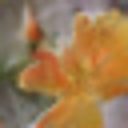

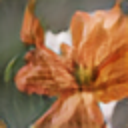

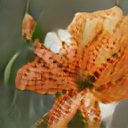

In [127]:
caps = ['this flower has petals that are orange and has black dots']
txt2img(caps, netG_flower, tokenizer)

this white flower has connected circular petals with yellow stamen


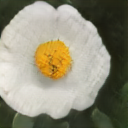

this flower has petals that are purple and has white shading


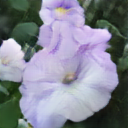

In [153]:
caps = ['this white flower has connected circular petals with yellow stamen', 
        'this flower has petals that are purple and has white shading']
txt2img(caps, netG_flower, tokenizer, only_last = True)

In [157]:
FLOWER_DATA_DIR = './flower'
BIRD_DATA_DIR = './bird'

with open(FLOWER_DATA_DIR + '/token_bert_test.pkl', 'rb') as f:
    caps_flower_test = pickle.load(f)
with open(FLOWER_DATA_DIR + '/attn_mask_test.pkl', 'rb') as f:
    attn_mask_flower_test = pickle.load(f)
with open(FLOWER_DATA_DIR + '/caps_text_test.pkl', 'rb') as f:
    text_flower_test = pickle.load(f)
    
caps_flower_test = [cap for caps in caps_flower_test for cap in caps]
attn_mask_flower_test = [am for ams in attn_mask_flower_test for am in ams]
text_flower_test = [text for texts in text_flower_test for text in texts]

this flower has petals that are pink with yellow lines


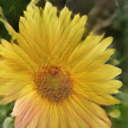

this flower is yellow in color , and has petals that are still opening up


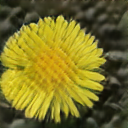

this flower has oval shaped petals that are white on the ends and yellow towards the middle of the flower


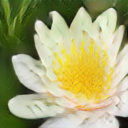

this flower has pointed green sepals and peach colored petals that are tightly layered


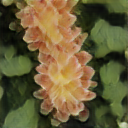

this flower has petals that are pink and has white stigma


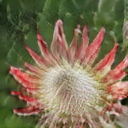

the petals are red in color and can attract a lot of pollinators


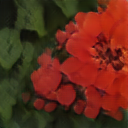

this flower has petals that are white and has a yellow stigma


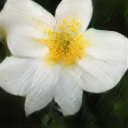

this flower is orange and pink in color , and has petals that are oval shaped and spotted


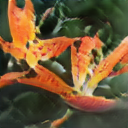

a flower with stacked petals that are red with yellow centers


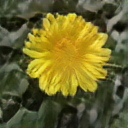

this flower has dark purple petals with irregular white markings on them


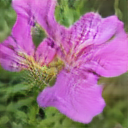

In [168]:
sample_from_testset(caps_flower_test, attn_mask_flower_test, text_flower_test,
                        netG_flower, num_samples = 10, only_last = True)

In [13]:
netG_bird = G_NET()
netG_bird_params = torch.load(BIRD_DATA_DIR + '/netG_epoch_350.pth')
netG_bird.load_state_dict(netG_params)
if cfg.CUDA:
    netG = netG.cuda()

this bird has a red stripe


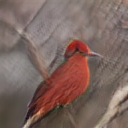

this small bird has a short pointed bill with dark brown,　orange　brown, tan, and white covering the rest of its body


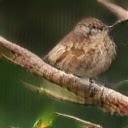

In [123]:
caps = ['this bird has a red stripe', 
        'this small bird has a short pointed bill with dark brown,　orange　brown, tan, and white covering the rest of its body', 
        'this is a multicolored bird with a light shade on its lower part , orange breast , blue head and small beak']
txt2img(caps, netG_bird, tokenizer, only_last = True)

In [92]:
with open(BIRD_DATA_DIR + '/token_bert_test.pkl', 'rb') as f:
    caps_bird_test = pickle.load(f)
with open(BIRD_DATA_DIR + '/attn_mask_test.pkl', 'rb') as f:
    attn_mask_bird_test = pickle.load(f)
with open(BIRD_DATA_DIR + '/caps_text_test.pkl', 'rb') as f:
    text_bird_test = pickle.load(f)
    
caps_bird_test = [cap for caps in caps_bird_test for cap in caps]
attn_mask_bird_test = [am for ams in attn_mask_bird_test for am in ams]
text_bird_test = [text for texts in text_bird_test for text in texts]

this is a little brown bird with a white throat


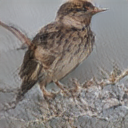

bird has long flat blue beak throat is white belly is rust color and the wings are blue as well as its head


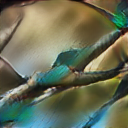

this is a grey bird with a yellow spot on its back


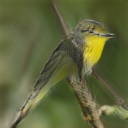

this bird has yellow neck , throat , crown and black wings , belly and breast , tail


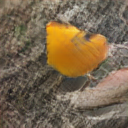

bird with black beak , dark gray tarsus and feet , and gray throat , breast , belly , abdomen and thigh


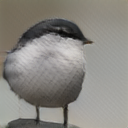

this is a multicolored bird with a light shade on its lower part , orange breast , blue head and small beak


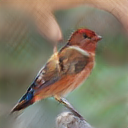

a long narrow black beak points out as the small white and black bird stays perched on a branch


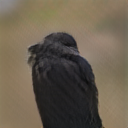

this bird is brown with black and has a very short beak


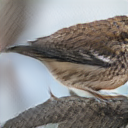

this bird has a gray and white breast and belly along with a black crown


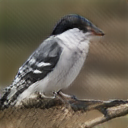

this bird has a brown crown as well as a white belly


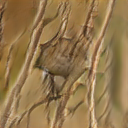

In [106]:
sample_from_testset(caps_bird_test, attn_mask_bird_test, text_bird_test,
                        netG_bird, num_samples = 10, only_last = True)